In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
import random

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from datetime import timedelta

In [ ]:


# Load datasets
data_fake = pd.read_csv('Fake.csv')
data_true = pd.read_csv('True.csv')

# Label the datasets
data_fake['class'] = 0
data_true['class'] = 1

# Clean and convert 'date' columns
data_fake['date'] = pd.to_datetime(data_fake['date'].astype(str).str.strip(), errors='coerce')
data_true['date'] = pd.to_datetime(data_true['date'].astype(str).str.strip(), errors='coerce')

# Calculate median dates
fake_median_date = data_fake['date'].median()
true_median_date = data_true['date'].median()

# Helper: Fill missing dates with small random variation around median
def randomize_date_around_median(median_date, size, spread_days=15):
    return [median_date + timedelta(days=random.randint(-spread_days, spread_days)) for _ in range(size)]

# Apply to fake dataset
na_fake = data_fake['date'].isna()
data_fake.loc[na_fake, 'date'] = randomize_date_around_median(fake_median_date, na_fake.sum())

# Apply to true dataset
na_true = data_true['date'].isna()
data_true.loc[na_true, 'date'] = randomize_date_around_median(true_median_date, na_true.sum())

# Separate manual testing data
data_fake_manual_testing = data_fake.tail(10).copy()
data_true_manual_testing = data_true.tail(10).copy()
data_fake = data_fake.iloc[:-10, :]
data_true = data_true.iloc[:-10, :]

data_fake_manual_testing['class'] = 0
data_true_manual_testing['class'] = 1

# Merge and shuffle dataset
data_merge = pd.concat([data_fake, data_true], axis=0)
data = data_merge.sample(frac=1).reset_index(drop=True)

# Preprocessing function
def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
data['text'] = data['text'].astype(str).apply(wordopt)

# Identify top 20 most common words
all_words = ' '.join(data['text']).split()
custom_top_words = [word for word, _ in Counter(all_words).most_common(20)]

print("\nTop 20 Most Common Words in Dataset:")
print(custom_top_words)

# Final stopwords list
stop_words = list(ENGLISH_STOP_WORDS) + custom_top_words

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply stopword removal
data['text'] = data['text'].apply(remove_stopwords)



Top 20 Most Common Words in Dataset:
['the', 'to', 'of', 'a', 'and', 'in', 'that', 'on', 's', 'for', 'is', 'said', 'he', 'it', 'with', 'was', 'trump', 'as', 'his', 'by']


In [ ]:


# Split features and labels
x = data['text']
y = data['class']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# TF-IDF Vectorization
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# Initialize models
LR = LogisticRegression()
DT = DecisionTreeClassifier()
GB = GradientBoostingClassifier(random_state=0)
RF = RandomForestClassifier(random_state=0)

# Train models
LR.fit(xv_train, y_train)
DT.fit(xv_train, y_train)
GB.fit(xv_train, y_train)
RF.fit(xv_train, y_train)

# Predictions
pred_lr = LR.predict(xv_test)
pred_dt = DT.predict(xv_test)
pred_gb = GB.predict(xv_test)
pred_rf = RF.predict(xv_test)

# Evaluation
print("\nLogistic Regression:\n", classification_report(y_test, pred_lr))
print("\nDecision Tree:\n", classification_report(y_test, pred_dt))
print("\nGradient Boosting:\n", classification_report(y_test, pred_gb))
print("\nRandom Forest:\n", classification_report(y_test, pred_rf))

# Label decoder
def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"

# Manual testing function
def manual_testing(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test['text'] = new_def_test['text'].apply(wordopt)
    new_def_test['text'] = new_def_test['text'].apply(remove_stopwords)
    new_xv_test = vectorization.transform(new_def_test['text'])

    pred_LR = LR.predict(new_xv_test)[0]
    pred_DT = DT.predict(new_xv_test)[0]
    pred_GB = GB.predict(new_xv_test)[0]
    pred_RF = RF.predict(new_xv_test)[0]

    print("\n\nLR Predicition: {}\nDT Prediction: {}\nGBC Prediction: {}\nRFC Prediction:{}".format(
        output_label(pred_LR),
        output_label(pred_DT),
        output_label(pred_GB),
        output_label(pred_RF)))

# Test manually
news = str(input("\nEnter News Text: "))
manual_testing(news)
news = str(input("\nEnter Another News Text: "))
manual_testing(news)


Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5771
           1       0.99      0.99      0.99      5449

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220


Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5771
           1       1.00      1.00      1.00      5449

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg       1.00      1.00      1.00     11220


Gradient Boosting:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      5771
           1       0.99      1.00      0.99      5449

    accuracy                           1.00     11220
   macro avg       1.00      1.00      1.00     11220
weighted avg 

In [ ]:
# news = str(input("\nEnter Another News Text: "))
# manual_testing(news)

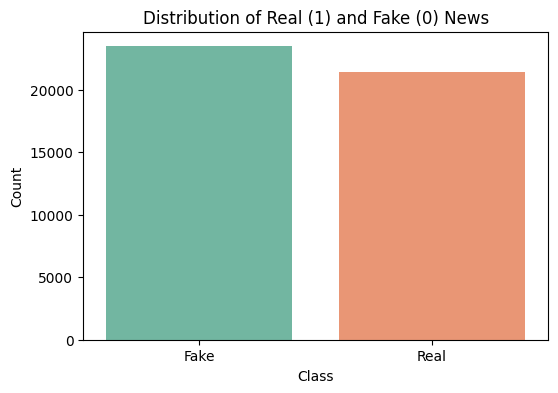

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='class', hue='class', palette="Set2", legend=False)
plt.title("Distribution of Real (1) and Fake (0) News")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


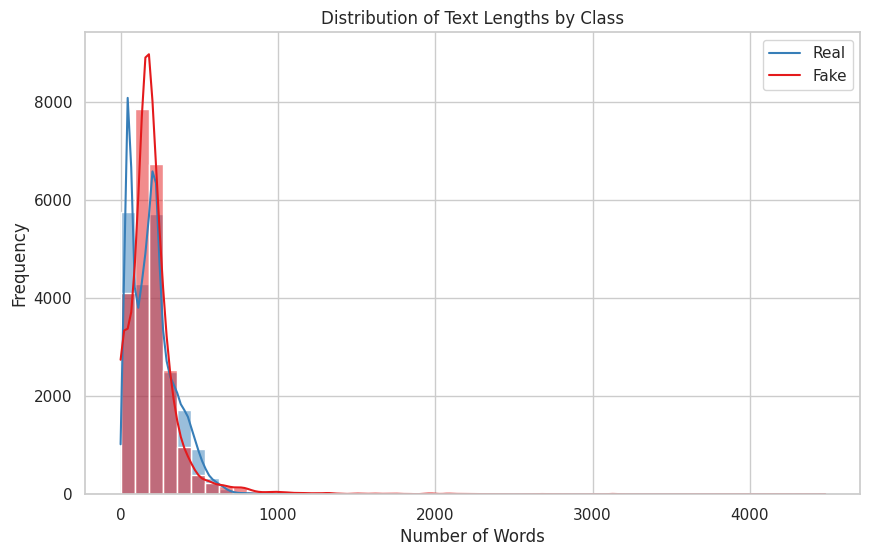

In [ ]:
# Add a new column for text length
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', bins=50, hue='class', kde=True, palette='Set1')
plt.title('Distribution of Text Lengths by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(labels=["Real", "Fake"])
plt.show()


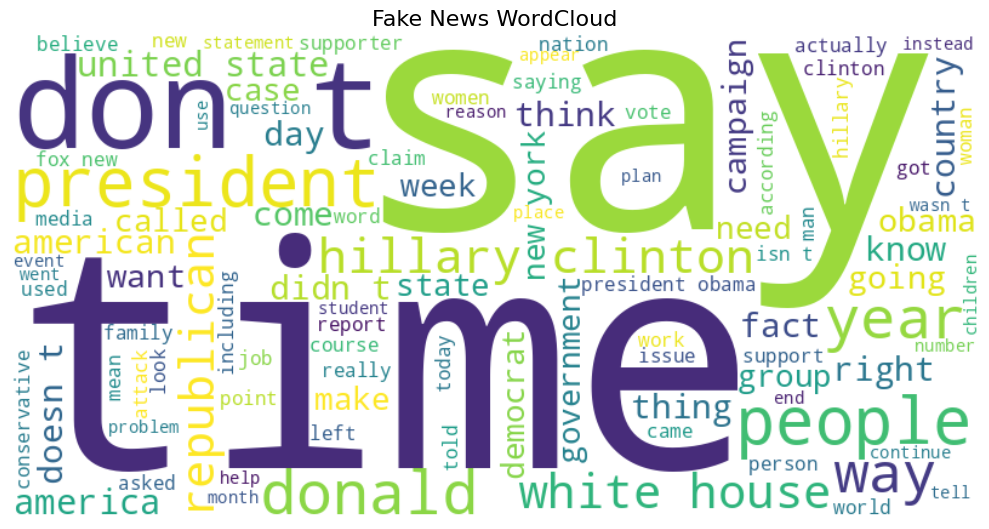

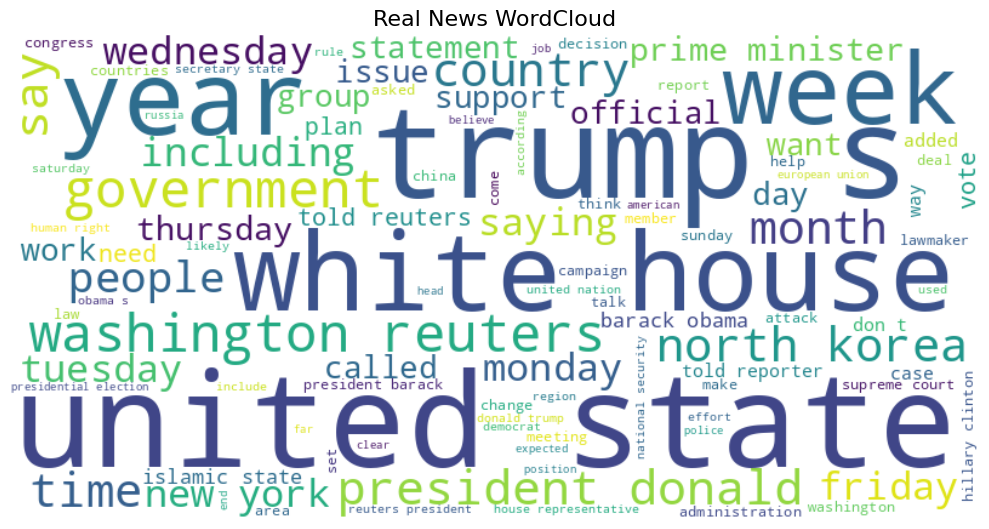

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split into fake and real
fake_text = ' '.join(data[data['class'] == 0]['text'])
real_text = ' '.join(data[data['class'] == 1]['text'])

# --- Fake News WordCloud ---
plt.figure(figsize=(10, 6))
wc_fake = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.title('Fake News WordCloud', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# --- Real News WordCloud ---
plt.figure(figsize=(10, 6))
wc_real = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(real_text)
plt.imshow(wc_real, interpolation='bilinear')
plt.title('Real News WordCloud', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


<ipython-input-16-5d840925a562>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='count', y='word', palette='magma')


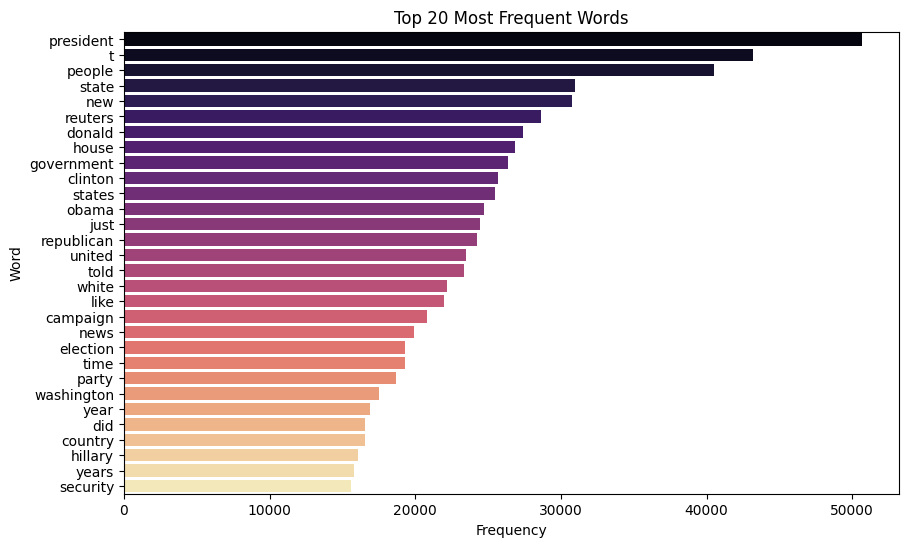

In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns

# Combine all text
all_words = ' '.join(data['text']).split()

# Count top words
common_words = Counter(all_words).most_common(30)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(10,6))
sns.barplot(data=words_df, x='count', y='word', palette='magma')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


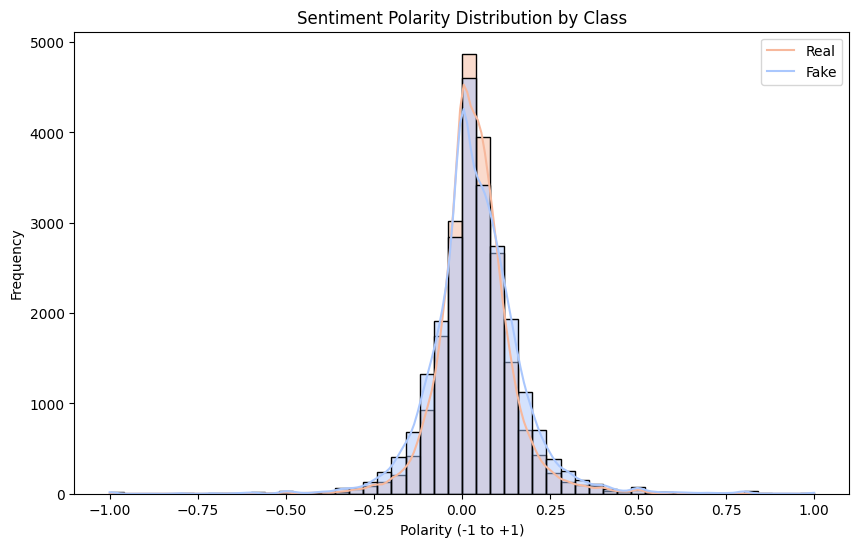

In [ ]:
from textblob import TextBlob

# Add sentiment polarity
data['polarity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(data=data, x='polarity', bins=50, hue='class', kde=True, palette='coolwarm')
plt.title('Sentiment Polarity Distribution by Class')
plt.xlabel('Polarity (-1 to +1)')
plt.ylabel('Frequency')
plt.legend(labels=["Real", "Fake"])
plt.show()


<ipython-input-18-e4c2c4f1a0a0>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='News Type')


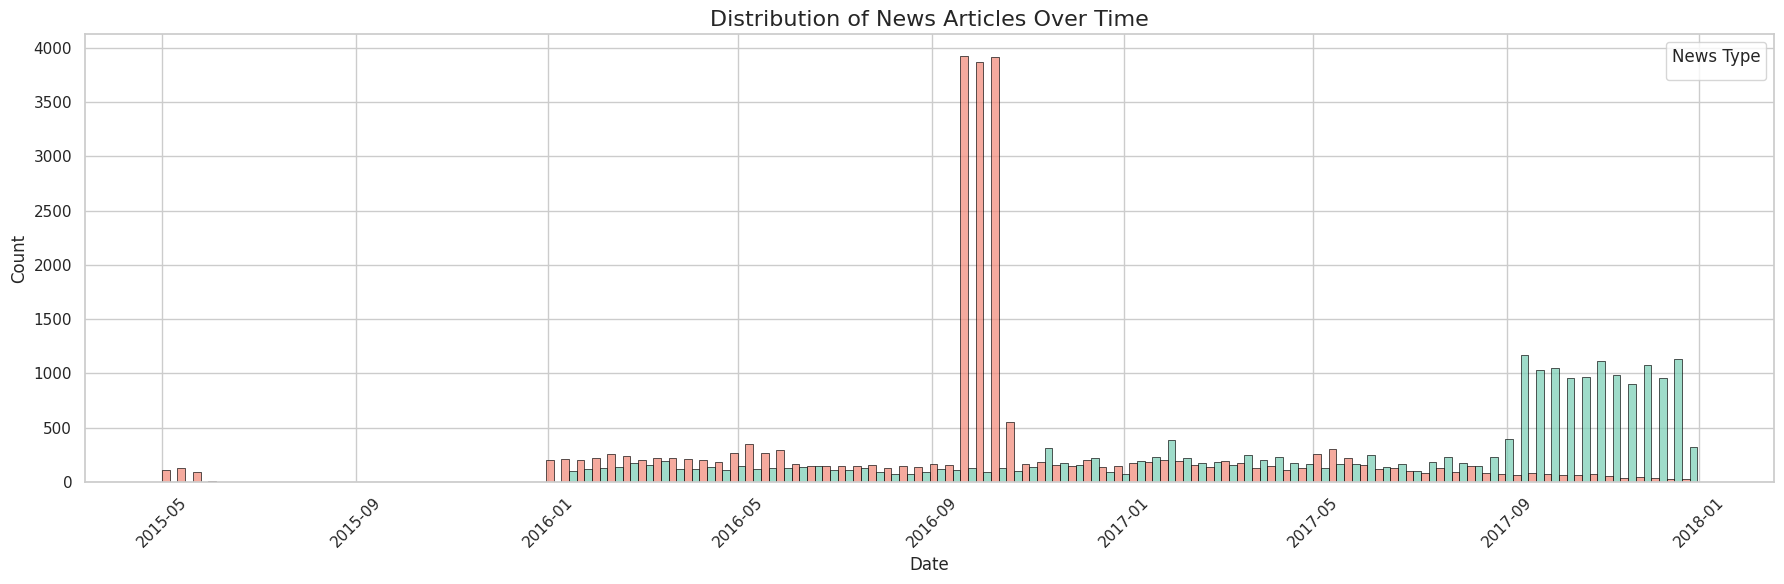

In [ ]:
# Make a copy to preserve original
plot_data = pd.concat([data_fake[['date', 'class']], data_true[['date', 'class']]], axis=0)

# Add a label column for legend
plot_data['label'] = plot_data['class'].map({0: 'Fake', 1: 'Real'})

# Set style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(18, 6))

# Use Seaborn for clear side-by-side bars using histplot with 'hue'
sns.histplot(data=plot_data,
             x='date',
             hue='label',
             bins=100,
             multiple='dodge',  # Separate bars side-by-side
             palette={'Fake': '#F28E7E', 'Real': '#7FD1B9'},
             edgecolor='black')

# Customize plot
plt.title('Distribution of News Articles Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='News Type')
plt.tight_layout()
plt.show()

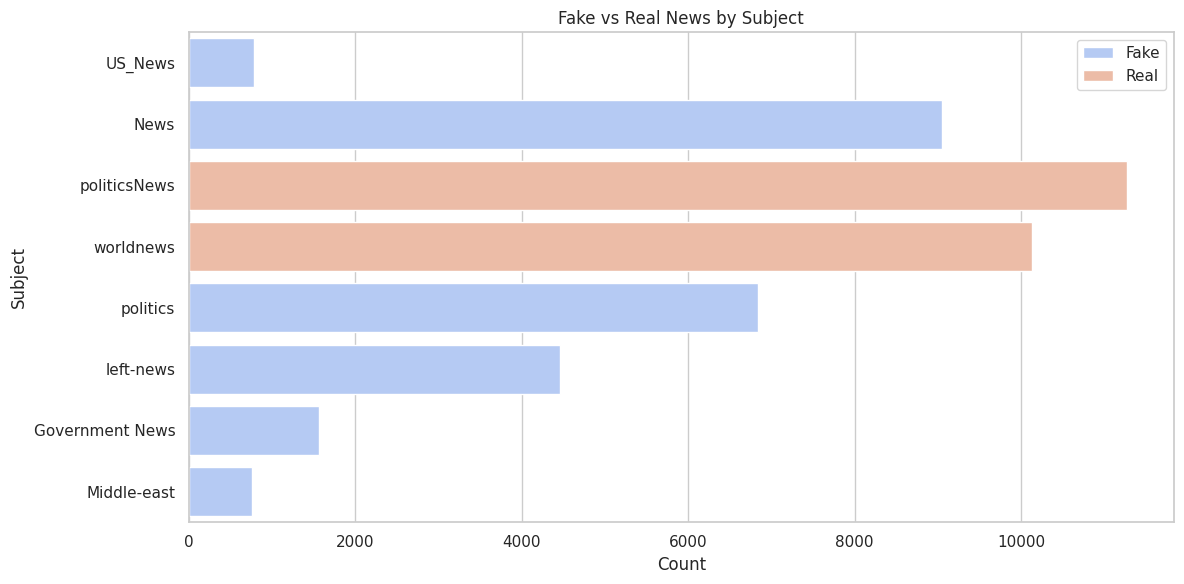

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='subject', data=data, hue='class', palette='coolwarm')
plt.title('Fake vs Real News by Subject')
plt.xlabel('Count')
plt.ylabel('Subject')
plt.legend(labels=['Fake', 'Real'])
plt.tight_layout()
plt.show()


In [ ]:
!pip install plotly --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:

# Imports
import pandas as pd
import plotly.graph_objects as go

# Assuming data_fake and data_true are already defined
data_fake['label'] = 'Fake'
data_true['label'] = 'Real'
combined_df = pd.concat([data_fake, data_true])
combined_df['month'] = combined_df['date'].dt.to_period('M').astype(str)

# Group by month and label
grouped = combined_df.groupby(['month', 'label']).size().reset_index(name='count')

# Convert month to numeric timestamp for x-axis
grouped['month_num'] = pd.to_datetime(grouped['month']).astype('int64') // 10**9

# Map labels to numbers
label_map = {'Fake': 0, 'Real': 1}
grouped['label_num'] = grouped['label'].map(label_map)

# Create 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=grouped['month_num'],
        y=grouped['label_num'],
        z=grouped['count'],
        mode='markers',
        marker=dict(
            size=8,
            color=grouped['label_num'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=grouped['label'] + " - " + grouped['month'],
        hoverinfo='text+z',
        name='Article Count'
    )
])

# Update layout
fig.update_layout(
    title='3D Distribution of Fake and Real News Over Time',
    scene=dict(
        xaxis=dict(title='Month'),
        yaxis=dict(title='News Type', tickvals=[0, 1], ticktext=['Fake', 'Real']),
        zaxis=dict(title='Count'),
    ),
    margin=dict(l=10, r=10, b=10, t=40)
)

fig.show()


In [ ]:


# # Split features and labels
# x = data['text']
# y = data['class']

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# # TF-IDF Vectorization
# vectorization = TfidfVectorizer()
# xv_train = vectorization.fit_transform(x_train)
# xv_test = vectorization.transform(x_test)

# # Initialize models
# LR = LogisticRegression()
# DT = DecisionTreeClassifier()
# GB = GradientBoostingClassifier(random_state=0)
# RF = RandomForestClassifier(random_state=0)

# # Train models
# LR.fit(xv_train, y_train)
# DT.fit(xv_train, y_train)
# GB.fit(xv_train, y_train)
# RF.fit(xv_train, y_train)

# # Predictions
# pred_lr = LR.predict(xv_test)
# pred_dt = DT.predict(xv_test)
# pred_gb = GB.predict(xv_test)
# pred_rf = RF.predict(xv_test)

# # Evaluation
# print("\nLogistic Regression:\n", classification_report(y_test, pred_lr))
# print("\nDecision Tree:\n", classification_report(y_test, pred_dt))
# print("\nGradient Boosting:\n", classification_report(y_test, pred_gb))
# print("\nRandom Forest:\n", classification_report(y_test, pred_rf))

# # Label decoder
# def output_label(n):
#     return "Fake News" if n == 0 else "Not A Fake News"

# # Manual testing function
# def manual_testing(news):
#     testing_news = {"text": [news]}
#     new_def_test = pd.DataFrame(testing_news)
#     new_def_test['text'] = new_def_test['text'].apply(wordopt)
#     new_def_test['text'] = new_def_test['text'].apply(remove_stopwords)
#     new_xv_test = vectorization.transform(new_def_test['text'])

#     pred_LR = LR.predict(new_xv_test)[0]
#     pred_DT = DT.predict(new_xv_test)[0]
#     pred_GB = GB.predict(new_xv_test)[0]
#     pred_RF = RF.predict(new_xv_test)[0]

#     print("\n\nLR Predicition: {}\nDT Prediction: {}\nGBC Prediction: {}\nRFC Prediction:{}".format(
#         output_label(pred_LR),
#         output_label(pred_DT),
#         output_label(pred_GB),
#         output_label(pred_RF)))

# # Test manually
# news = str(input("\nEnter News Text: "))
# manual_testing(news)
# news = str(input("\nEnter Another News Text: "))
# manual_testing(news)

In [ ]:
import plotly.express as px

# Group and reset
grouped_anim = combined_df.groupby(['month', 'label']).size().reset_index(name='count')

# Plot
fig = px.bar(grouped_anim,
             x='label',
             y='count',
             color='label',
             animation_frame='month',
             title='Monthly Evolution of Fake vs Real News',
             labels={'label': 'News Type', 'count': 'Article Count'},
             color_discrete_map={'Fake': 'crimson', 'Real': 'royalblue'})

fig.update_layout(yaxis_range=[0, grouped_anim['count'].max() + 50])
fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---- Step 1: Prepare the data ----
grouped_anim = combined_df.groupby(['month', 'label']).size().reset_index(name='count')

monthly_counts = combined_df.groupby(['month', 'label']).size().unstack().fillna(0).reset_index()

# ---- Step 2: Create subplots layout ----
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=("Bar Chart: Fake vs Real News Each Month", "Line Chart: Monthly Trend of Fake & Real News")
)

# ---- Step 3: Bar chart for each month ----
# Reshape to wide format for grouped bar
bar_df = grouped_anim.pivot(index='month', columns='label', values='count').fillna(0).reset_index()

fig.add_trace(
    go.Bar(
        x=bar_df['month'],
        y=bar_df['Fake'],
        name='Fake News',
        marker_color='crimson'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=bar_df['month'],
        y=bar_df['Real'],
        name='Real News',
        marker_color='royalblue'
    ),
    row=1, col=1
)

# ---- Step 4: Line chart for trend ----
fig.add_trace(
    go.Scatter(
        x=monthly_counts['month'],
        y=monthly_counts['Fake'],
        mode='lines+markers',
        name='Fake News (Trend)',
        line=dict(color='crimson')
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=monthly_counts['month'],
        y=monthly_counts['Real'],
        mode='lines+markers',
        name='Real News (Trend)',
        line=dict(color='royalblue')
    ),
    row=2, col=1
)

# ---- Step 5: Final layout ----
fig.update_layout(
    title='Fake vs Real News Analysis by Month',
    height=800,
    barmode='group',
    showlegend=True,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5),
    margin=dict(t=80)
)

fig.update_yaxes(title_text="Article Count", row=1, col=1)
fig.update_yaxes(title_text="Article Count", row=2, col=1)
fig.update_xaxes(title_text="Month", row=2, col=1)

fig.show()


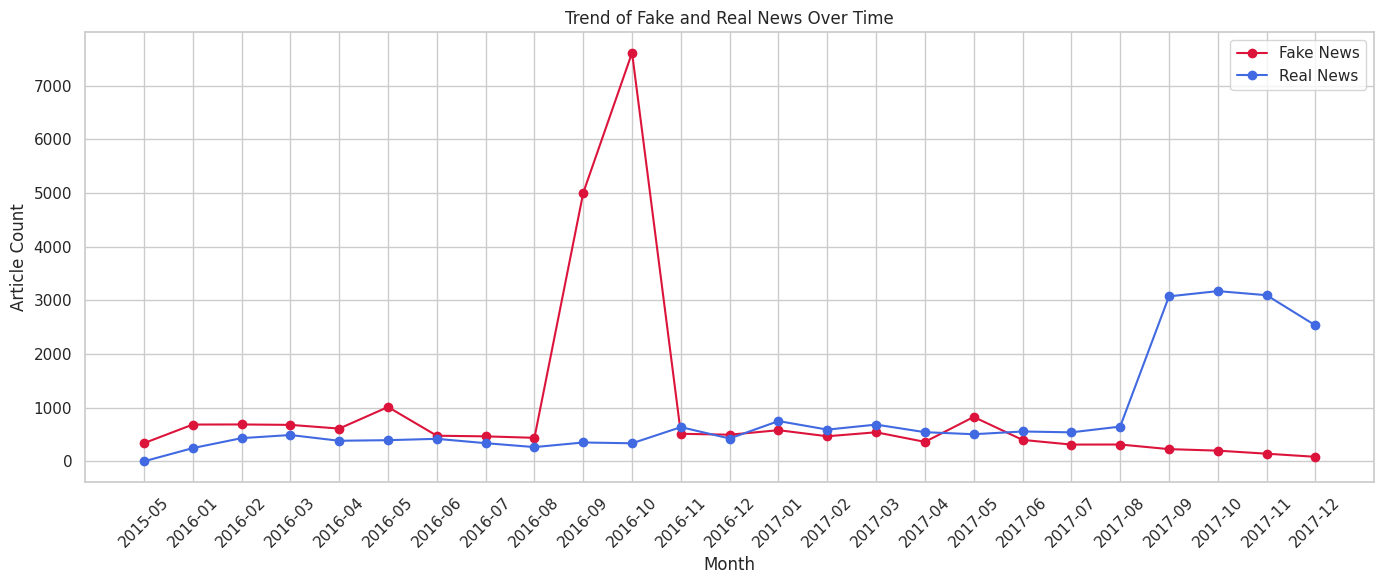

In [ ]:
monthly_counts = combined_df.groupby(['month', 'label']).size().unstack().fillna(0)

plt.figure(figsize=(14, 6))
plt.plot(monthly_counts.index, monthly_counts['Fake'], marker='o', color='crimson', label='Fake News')
plt.plot(monthly_counts.index, monthly_counts['Real'], marker='o', color='royalblue', label='Real News')

plt.title('Trend of Fake and Real News Over Time')
plt.xlabel('Month')
plt.ylabel('Article Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


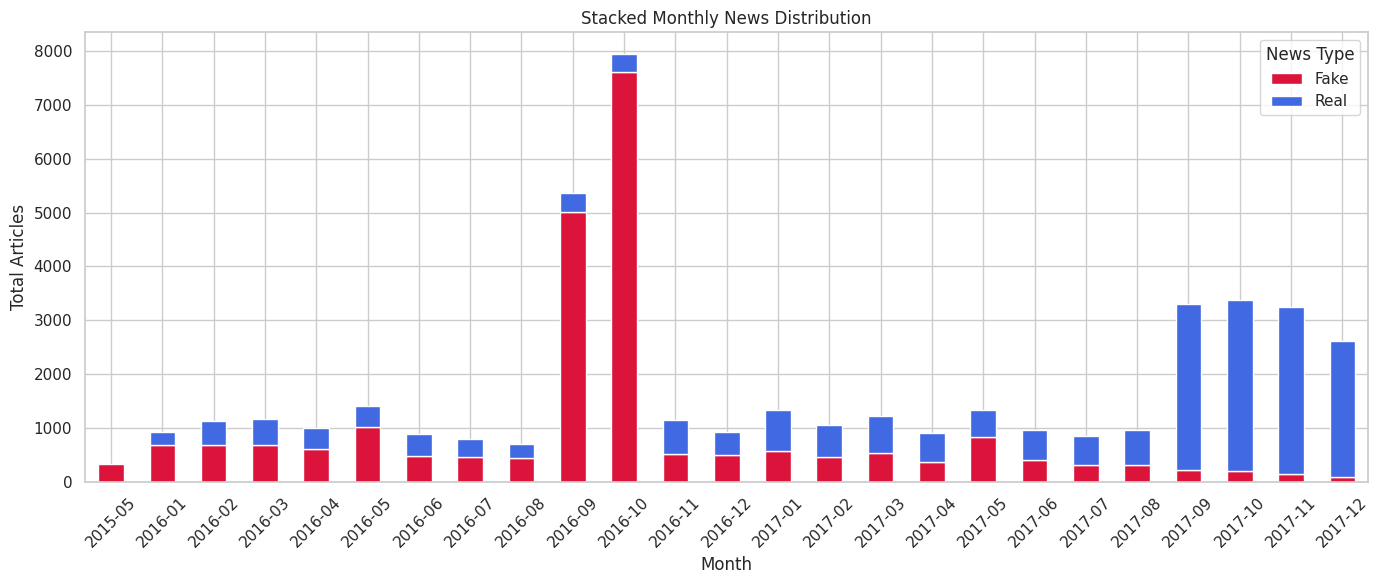

In [ ]:
monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 6), color=['crimson', 'royalblue'])

plt.title('Stacked Monthly News Distribution')
plt.xlabel('Month')
plt.ylabel('Total Articles')
plt.xticks(rotation=45)
plt.legend(title='News Type')
plt.tight_layout()
plt.show()


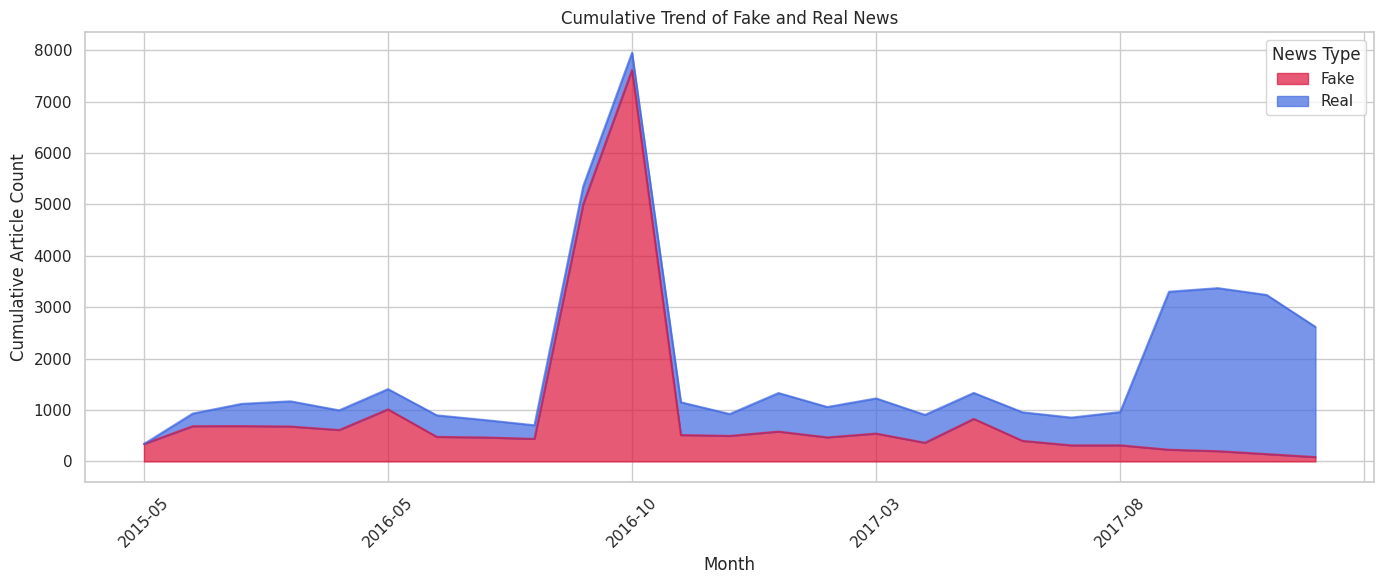

In [ ]:
monthly_counts.plot(kind='area', stacked=True, figsize=(14, 6), color=['crimson', 'royalblue'], alpha=0.7)

plt.title('Cumulative Trend of Fake and Real News')
plt.xlabel('Month')
plt.ylabel('Cumulative Article Count')
plt.xticks(rotation=45)
plt.legend(title='News Type')
plt.tight_layout()
plt.show()


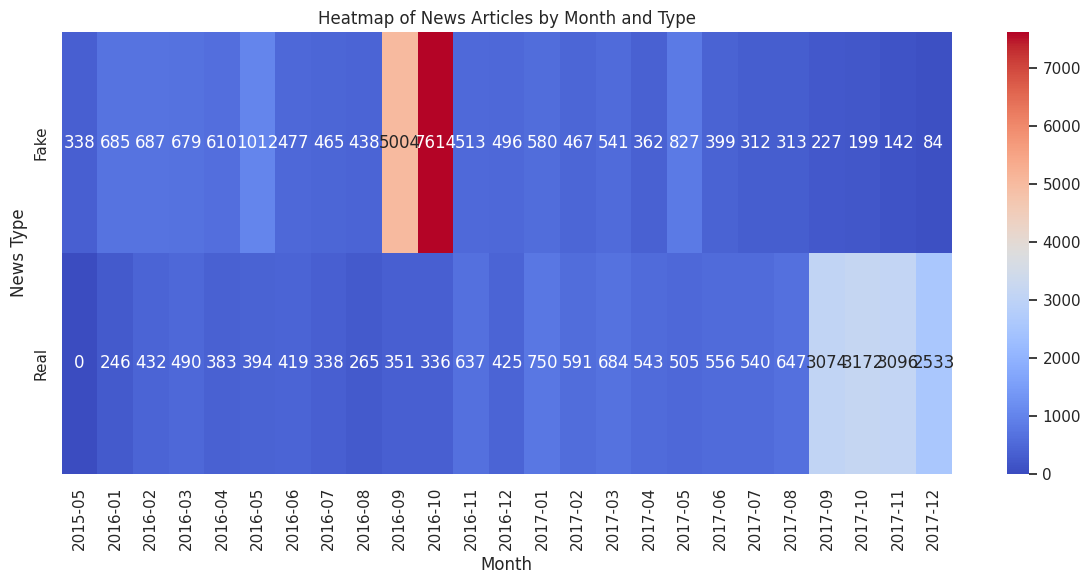

In [ ]:
heatmap_data = combined_df.groupby(['month', 'label']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap='coolwarm', annot=True, fmt='g')

plt.title('Heatmap of News Articles by Month and Type')
plt.xlabel('Month')
plt.ylabel('News Type')
plt.tight_layout()
plt.show()


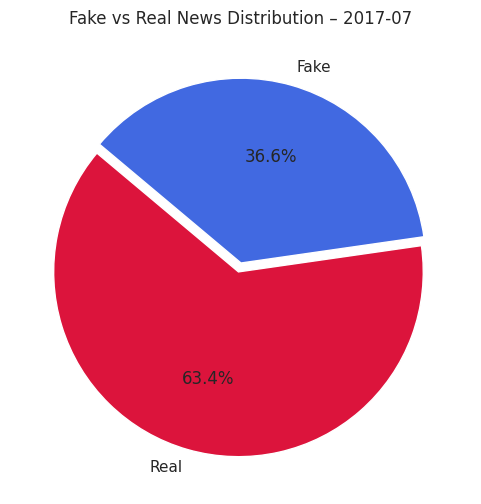

In [ ]:
# Select a specific month
target_month = '2017-07'
df_month = combined_df[combined_df['month'] == target_month]

# Count fake vs real
label_counts = df_month['label'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
        startangle=140, colors=['crimson', 'royalblue'], explode=[0.05, 0])
plt.title(f'Fake vs Real News Distribution – {target_month}')
plt.show()


In [ ]:
# Add this BEFORE any of the plots
combined_df['text_length'] = combined_df['text'].apply(lambda x: len(str(x).split()))


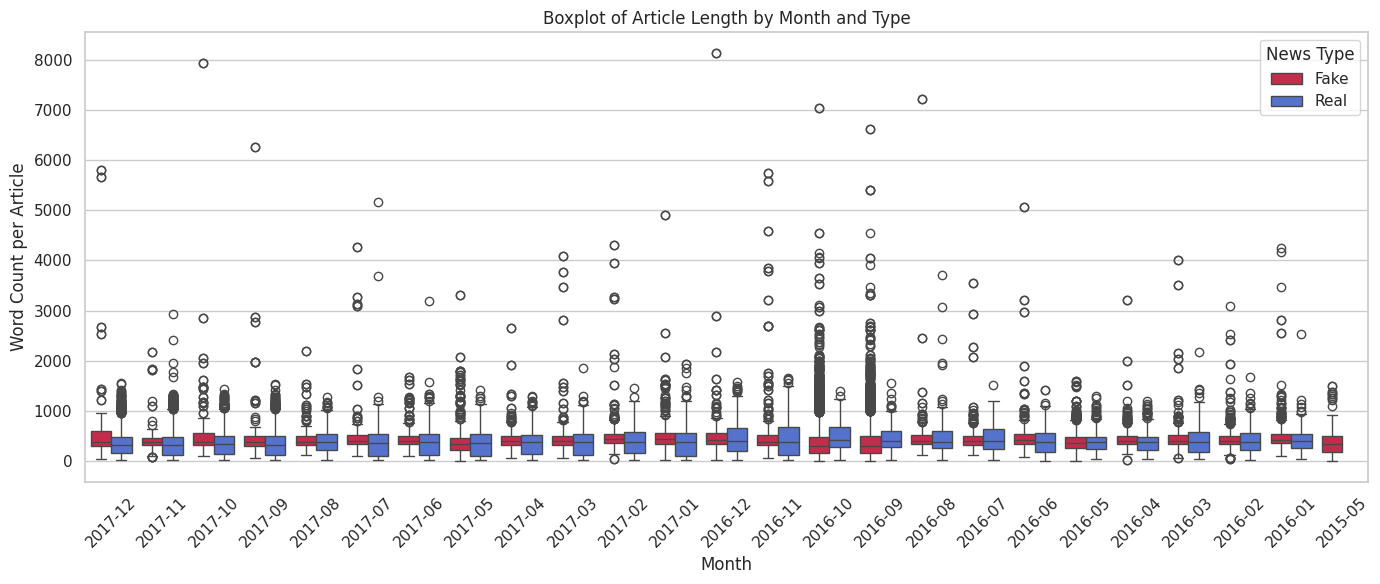

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df, x='month', y='text_length', hue='label',
            palette={'Fake': 'crimson', 'Real': 'royalblue'})

plt.title('Boxplot of Article Length by Month and Type')
plt.xlabel('Month')
plt.ylabel('Word Count per Article')
plt.xticks(rotation=45)
plt.legend(title='News Type')
plt.tight_layout()
plt.show()


<ipython-input-45-89e2a3408dd6>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




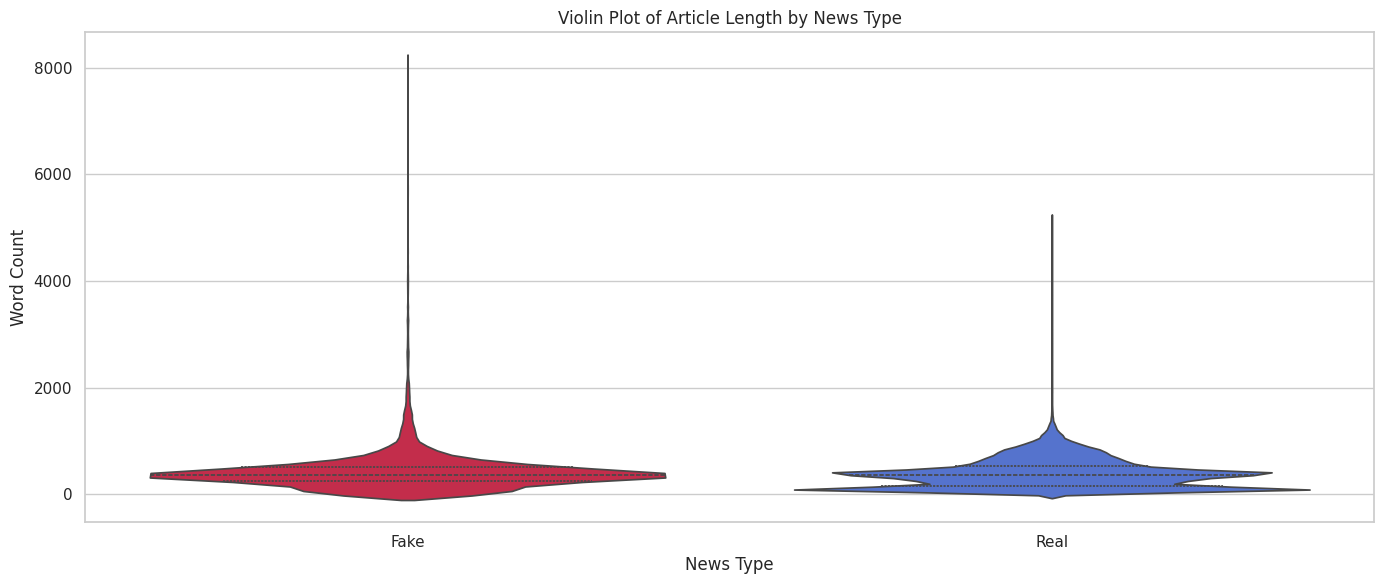

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=combined_df, x='label', y='text_length',
               palette={'Fake': 'crimson', 'Real': 'royalblue'}, inner='quartile')

plt.title('Violin Plot of Article Length by News Type')
plt.xlabel('News Type')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()


<ipython-input-42-1a0a1e6a1bb3>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




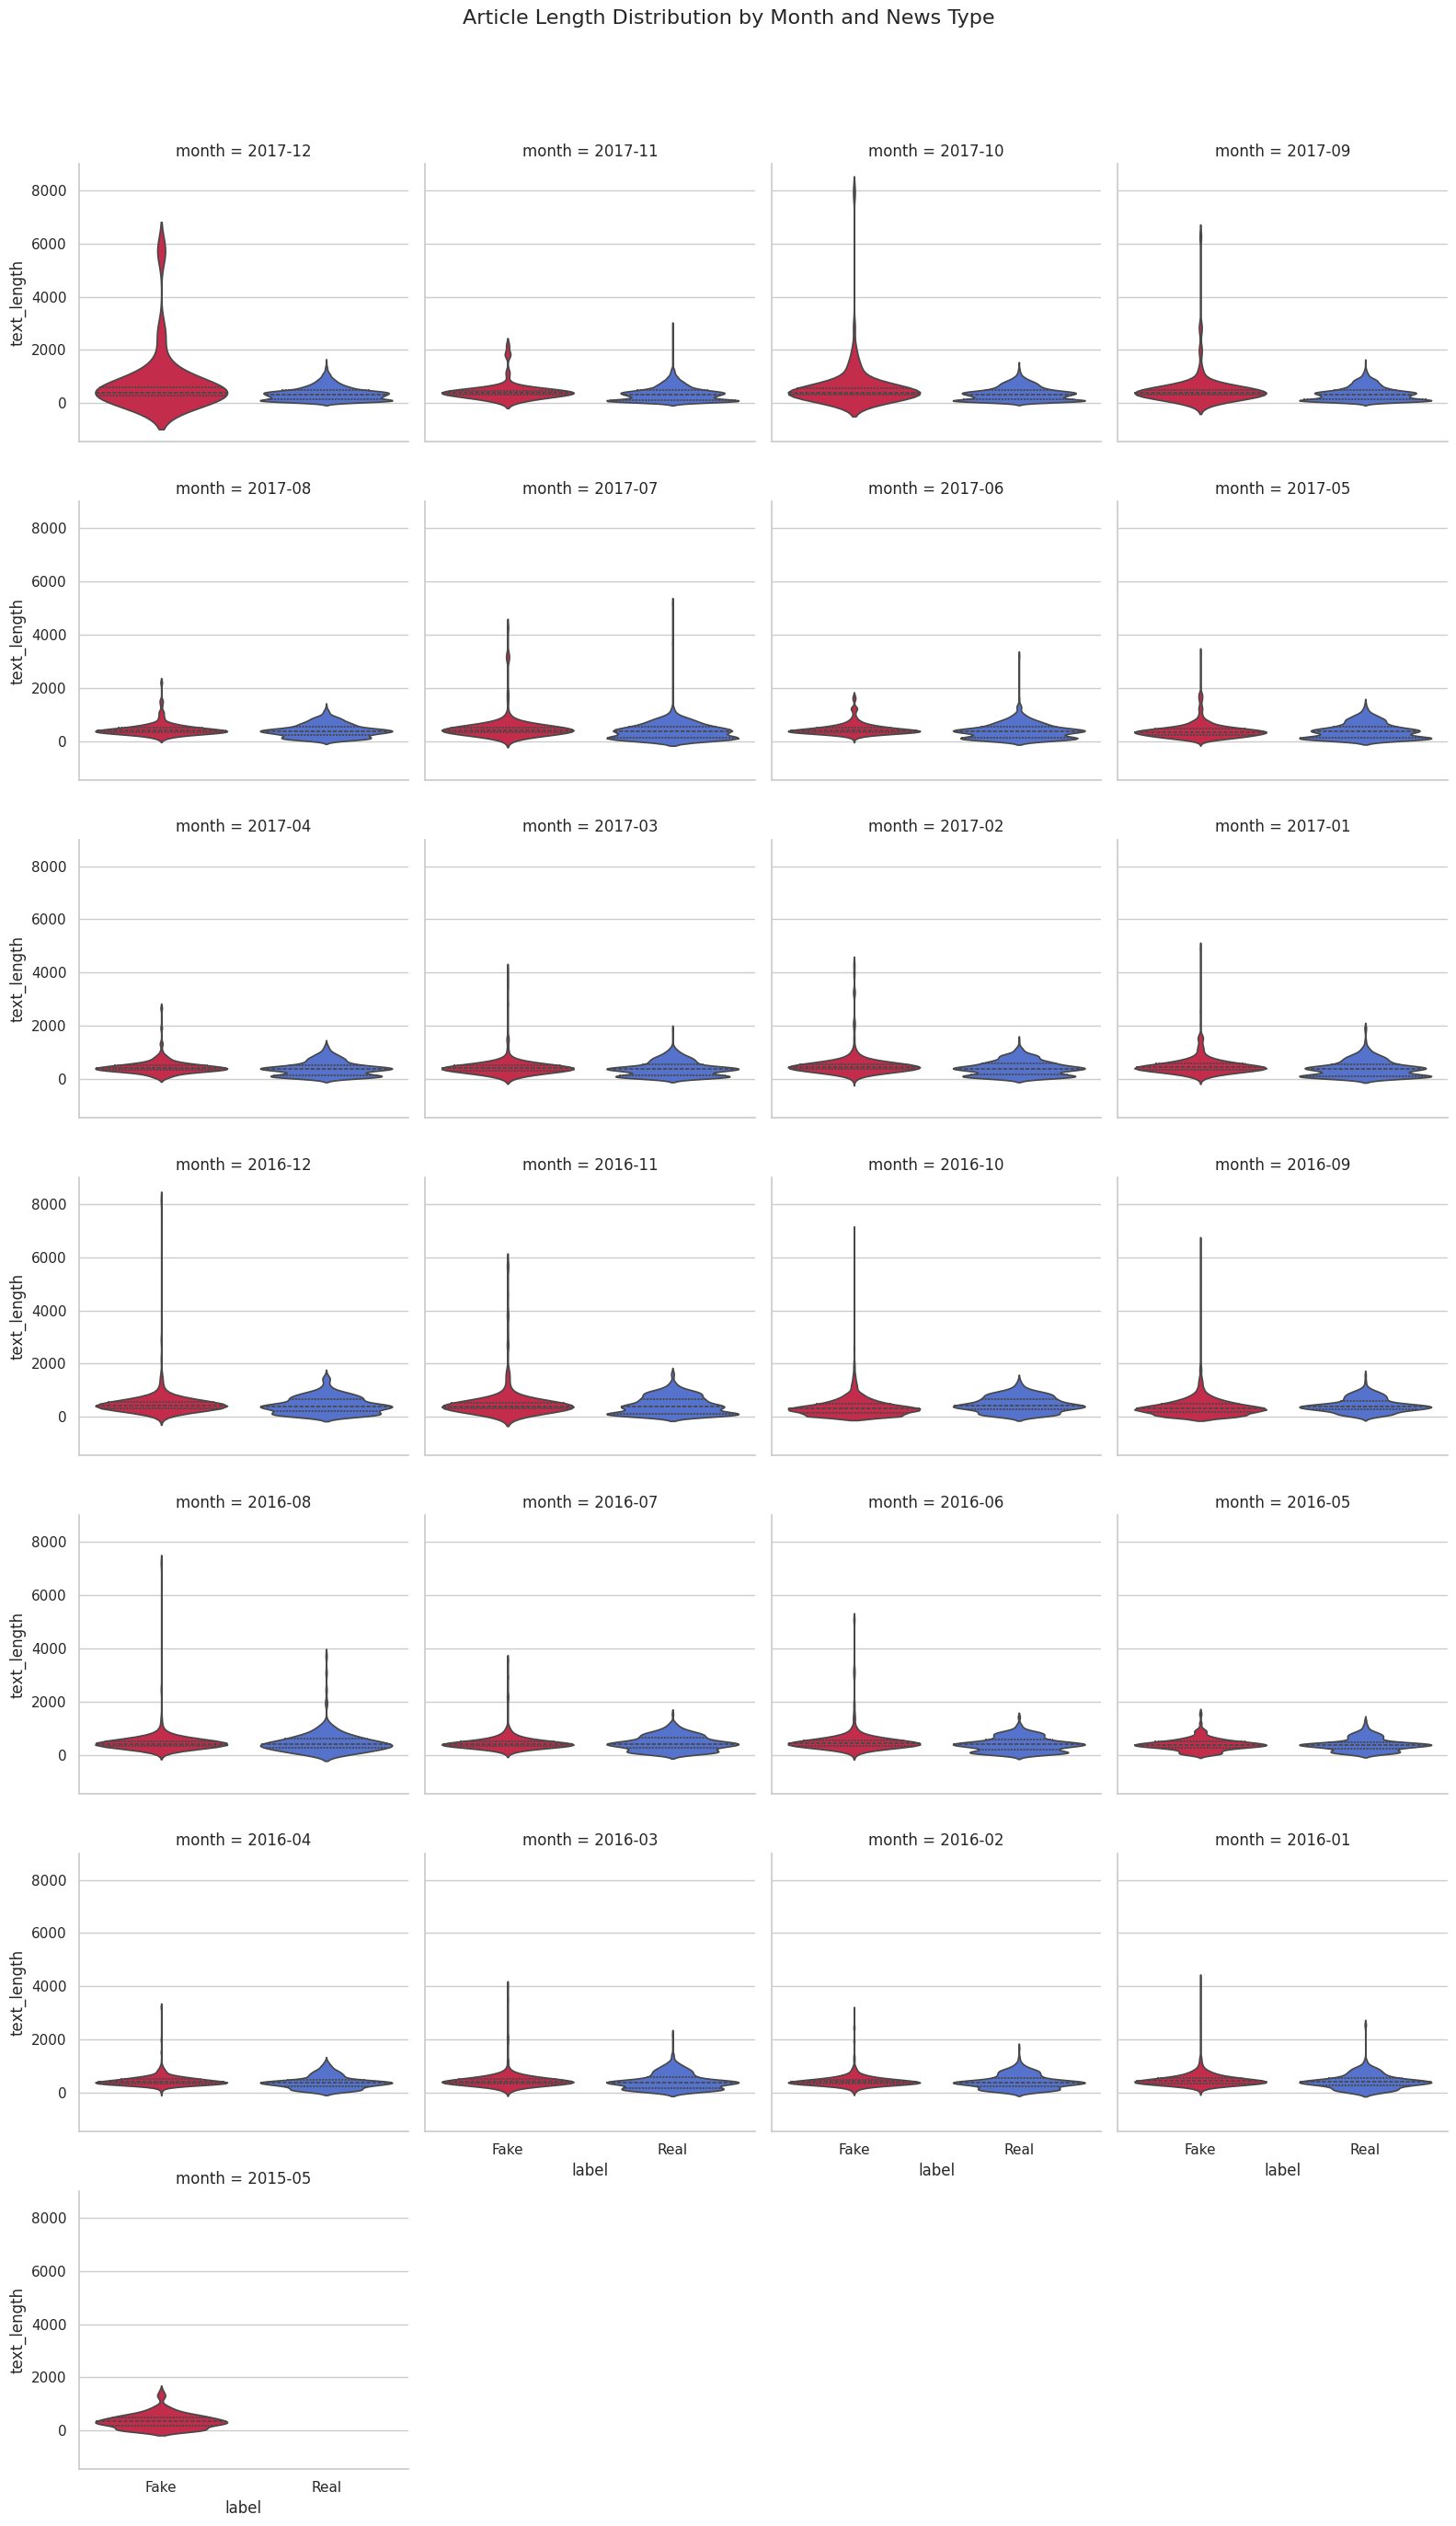

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Then use the same plot code with filtered_df instead of combined_df


# STEP 1: Ensure 'text_length' and 'month' columns exist
combined_df['text_length'] = combined_df['text'].apply(lambda x: len(str(x).split()))
combined_df['month'] = combined_df['date'].dt.to_period('M').astype(str)



# STEP 2: Plot violin plots using FacetGrid
g = sns.catplot(
    data=combined_df,
    x='label', y='text_length',
    col='month', col_wrap=4,
    kind='violin',
    palette={'Fake': 'crimson', 'Real': 'royalblue'},
    inner='quartile',
    height=4, aspect=1
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Article Length Distribution by Month and News Type', fontsize=16)

plt.show()


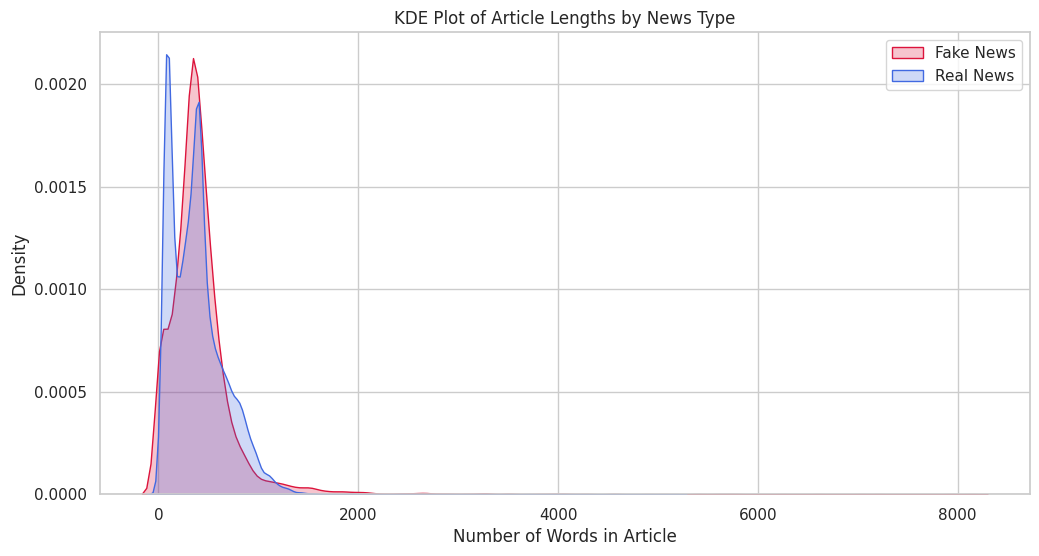

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=combined_df[combined_df['label'] == 'Fake'], x='text_length', label='Fake News', color='crimson', fill=True)
sns.kdeplot(data=combined_df[combined_df['label'] == 'Real'], x='text_length', label='Real News', color='royalblue', fill=True)
plt.title('KDE Plot of Article Lengths by News Type')
plt.xlabel('Number of Words in Article')
plt.ylabel('Density')
plt.legend()
plt.show()


<ipython-input-35-a0a9b44b8561>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




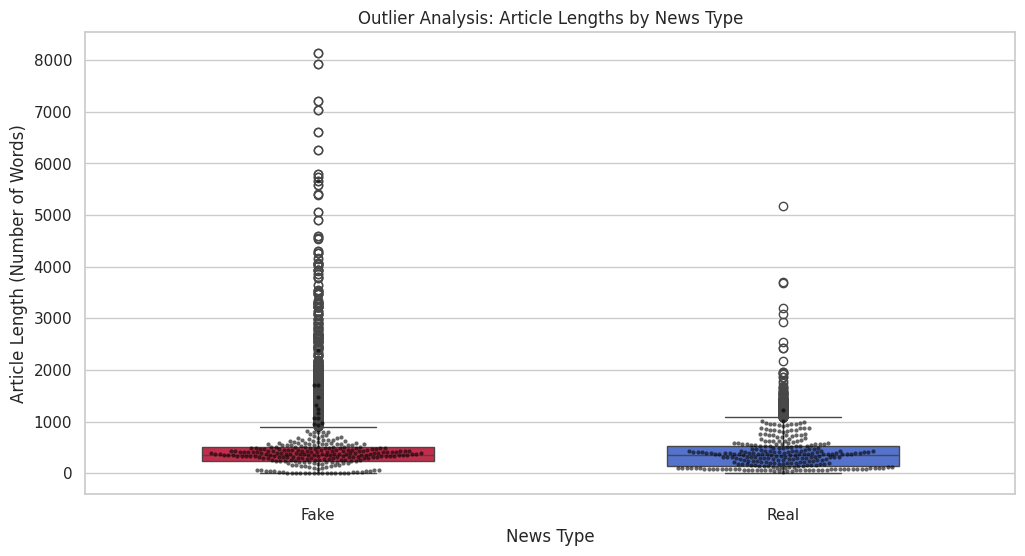

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Boxplot (shows IQR, median, whiskers, and outliers)
sns.boxplot(data=combined_df, x='label', y='text_length',
            palette={'Fake': 'crimson', 'Real': 'royalblue'}, width=0.5)

# Swarmplot (shows each data point to visualize spread + outliers)
sns.swarmplot(data=combined_df.sample(500),  # sample to avoid clutter
              x='label', y='text_length',
              color='black', size=3, alpha=0.6)

plt.title('Outlier Analysis: Article Lengths by News Type')
plt.xlabel('News Type')
plt.ylabel('Article Length (Number of Words)')
plt.show()
